Nama : Jonathan Christopher Gani  
NIM : 2702223084


# UTS Text Mining

# Load Libraries

In [ ]:
!pip install google-play-scraper

import warnings
warnings.filterwarnings("ignore")
!pip install gensim

# install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 66.8 MB/s eta 0:00:00


In [ ]:
# importing neccessary libraries
from google_play_scraper import reviews, Sort
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import nltk
import re
from nltk.corpus import words as nltk_words
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
nltk.download('words')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')



[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

Disini, saya menginstall google play scraper dan gensim terlebih dahulu, kemudian mengimport library-library yang diperlukan

# 1. Pengumpulan Data Review Games (Web Scrapping)

In [ ]:
# data collection
all_reviews = []   # empty list buat nyimpen semua review
token = None
batch = 0

while True:
    batch += 1

    result, token = reviews(
        'com.supercell.clashroyale',  # ID Clash Royale
        lang='en',                    # bahasa inggris
        country='us',                 # dari US
        sort=Sort.NEWEST,             # review terbaru
        count=100,                    # ambil 100 review/batch, supaya aman
        continuation_token=token      # lanjut dari batch terakhir biar ga ngulang
    )

    all_reviews.extend(result)
    print(f"Total terkumpul batch {batch} : {len(all_reviews)} review")


    if not token or len(all_reviews) >= 1000:
        break

    time.sleep(10)  # jeda 10 detik antar batch

# convert jadi DataFrame dan save as CSV
dataset = pd.DataFrame(all_reviews)
dataset.to_csv('clashroyale_reviews_raw.csv', index=False)

print(f"\nTotal review tersimpan: {len(dataset)}")


Total terkumpul batch 1 : 100 review
Total terkumpul batch 2 : 200 review
Total terkumpul batch 3 : 300 review
Total terkumpul batch 4 : 400 review
Total terkumpul batch 5 : 500 review
Total terkumpul batch 6 : 600 review
Total terkumpul batch 7 : 700 review
Total terkumpul batch 8 : 800 review
Total terkumpul batch 9 : 900 review
Total terkumpul batch 10 : 1000 review

Total review tersimpan: 1000


Disini, saya melakukan pengumpulan data review game Clash Royale melalui web scraping. Berdasarkan riset yang saya lakukan terkait web scraping untuk playstore itu sebenarnya dilarang, sehingga solusi terbaik untuk mengambil datanya adalah dengan tidak terlalu banyak (all at once). Sehingga saya menarik data secara batching, yakni 100 100, tidak langsung 1000 dengan jeda 10 detik antar batch. Disini saya menggunakan looping, yang akan mengambil review berbahasa inggris dari playstore di negara US (Amerika), kemudian mengambil yang data paling baru (updated). Kemudian hasil scraping tiap batch saya masukkan ke list utama dan akan berhenti scraping apabila sumber reviewnya sudah habis / sudah mencapai 1000. Kemudian saya memasukkan dan mengconvert semua hasil scrapingnya ke dalam 1 file CSV.

In [ ]:
data = pd.read_csv('clashroyale_reviews_raw.csv')
data

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,010d750d-31a2-489b-b919-cc6f6f443047,Prahllada Sannamani,https://play-lh.googleusercontent.com/a/ACg8oc...,super,5,0,120169018,2025-11-05 06:43:35,NaN,NaN,120169018
1,d2ba26eb-00cb-4e4a-87ad-ac7997dbf382,Oliver King,https://play-lh.googleusercontent.com/a/ACg8oc...,good game,5,0,120169018,2025-11-05 06:38:22,NaN,NaN,120169018
2,dcef5374-343b-4373-b977-d94358626154,shyam ghevariya,https://play-lh.googleusercontent.com/a-/ALV-U...,"Matchmaking is horrible, I get 2+ levels highe...",1,0,120169018,2025-11-05 06:34:13,NaN,NaN,120169018
3,3eba29e9-1d8f-4ede-bce4-5bb3e4d73ac6,MarK,https://play-lh.googleusercontent.com/a-/ALV-U...,goblin,5,0,120169018,2025-11-05 06:31:07,NaN,NaN,120169018
4,6cc9b620-b028-490e-8593-5fbee48f96e4,julio vasquez,https://play-lh.googleusercontent.com/a/ACg8oc...,pay to win. if you dont pay they play you with...,1,1,120169018,2025-11-05 06:30:39,NaN,NaN,120169018
...,...,...,...,...,...,...,...,...,...,...,...
995,7f5238fe-af4d-4455-a3aa-c47c913465fb,axo,https://play-lh.googleusercontent.com/a-/ALV-U...,6-7 out of 10,5,0,120169018,2025-11-03 06:20:51,NaN,NaN,120169018
996,6b2ad91e-3a24-41b2-ad89-13a6f8b951b1,Oaklee,https://play-lh.googleusercontent.com/a/ACg8oc...,going against a level 15 mega knight and princ...,1,0,120169018,2025-11-03 06:20:20,NaN,NaN,120169018
997,abba5372-27b3-45be-898f-7b569dba0614,Sebastian Ramirez,https://play-lh.googleusercontent.com/a-/ALV-U...,laggy,3,0,120169018,2025-11-03 06:12:39,NaN,NaN,120169018
998,ca01bad8-012c-4890-9944-b6b09e4ded59,Fetoai Paulo,https://play-lh.googleusercontent.com/a-/ALV-U...,it a good game that why I put 5,5,0,120169018,2025-11-03 06:05:31,NaN,NaN,120169018


In [ ]:
data.columns

Index(['reviewId', 'userName', 'userImage', 'content', 'score',
       'thumbsUpCount', 'reviewCreatedVersion', 'at', 'replyContent',
       'repliedAt', 'appVersion'],
      dtype='object')

In [ ]:
filtered_data = data[['content', 'score']]
filtered_data
# content = review bahasa inggris
# score = rating

,content,score
0,super,5
1,good game,5
2,"Matchmaking is horrible, I get 2+ levels highe...",1
3,goblin,5
4,pay to win. if you dont pay they play you with...,1
...,...,...
995,6-7 out of 10,5
996,going against a level 15 mega knight and princ...,1
997,laggy,3
998,it a good game that why I put 5,5


Kemudian saya membaca file csv review Clash Royale ini yang terdiri dari 1000 rows dengan total 11 kolom. Serta saya mengecek judul tiap kolom yang ada untuk mengetahui kolom mana saja yang akan digunakan nantinya. Karena tujuan utama tugas ini adalah membangun model prediksi rating, maka hanya kolom "content" dan "score" saja yang diperlukan.

# 2. Exploratory Data Analysis


In [ ]:
filtered_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  1000 non-null   object
 1   score    1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


In [ ]:
filtered_data.isna().sum()

,0
content,0
score,0


Melalui pengecekan .info() dan cek missing value, dapat dilihat bahwa dataset ini terbebas dari missing value, alias semua entry datanya terisi dengan baik. Sehingga tidak perlu untuk melakukan missing values handling.

In [ ]:
word_counts = [len(doc.split()) for doc in filtered_data['content']]
print(word_counts)

[1, 2, 24, 1, 50, 4, 3, 36, 3, 16, 9, 2, 24, 3, 5, 1, 5, 7, 15, 16, 2, 1, 10, 4, 1, 2, 8, 6, 28, 1, 12, 5, 2, 46, 5, 24, 2, 5, 2, 19, 6, 5, 23, 41, 28, 5, 45, 55, 14, 81, 4, 21, 19, 1, 2, 3, 9, 12, 6, 78, 9, 27, 11, 2, 1, 14, 33, 3, 21, 1, 17, 2, 2, 26, 2, 3, 8, 6, 16, 2, 1, 10, 2, 43, 19, 7, 2, 6, 2, 23, 17, 4, 2, 2, 2, 72, 3, 3, 26, 39, 7, 2, 3, 1, 9, 17, 5, 3, 7, 4, 10, 6, 7, 25, 2, 26, 2, 27, 5, 1, 4, 2, 17, 11, 5, 2, 2, 2, 101, 3, 2, 9, 55, 10, 3, 2, 24, 1, 4, 23, 12, 6, 2, 11, 56, 15, 5, 70, 6, 1, 1, 33, 68, 2, 13, 56, 5, 12, 6, 1, 11, 2, 1, 4, 1, 2, 5, 1, 22, 5, 7, 2, 1, 3, 5, 11, 14, 6, 11, 33, 8, 13, 10, 31, 2, 11, 41, 5, 22, 35, 40, 3, 4, 4, 2, 11, 43, 2, 3, 35, 24, 15, 9, 3, 18, 6, 5, 3, 2, 8, 7, 12, 56, 2, 1, 95, 7, 18, 2, 5, 12, 3, 3, 2, 89, 13, 1, 22, 32, 29, 1, 18, 7, 5, 4, 82, 2, 5, 4, 1, 11, 1, 31, 6, 4, 2, 78, 6, 88, 9, 12, 40, 25, 2, 1, 11, 47, 13, 2, 6, 2, 8, 19, 30, 16, 51, 3, 2, 2, 3, 2, 2, 7, 15, 2, 12, 2, 11, 16, 6, 4, 4, 1, 20, 24, 14, 38, 20, 3, 48, 8, 1, 1, 1

Pengecekan jumlah word / kata tiap row data

In [ ]:
rating_counts = filtered_data['score'].value_counts().sort_index()
rating_counts

,count
score,
1,292
2,38
3,48
4,71
5,551


Dapat dilihat frekuensi dari masing-masing score / rating, hasilnya menunjukkan kalau persebaran nya tidak merata alias imbalance, cenderung condong ke kedua ujung, yakni 1 dan 5, dengan rating 2 3 4 berada dalam range jumlah yang cukup dekat.

## Data Imbalance


/tmp/ipython-input-3555524208.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='score', data=filtered_data, order=sorted(filtered_data['score'].unique()), palette='viridis')


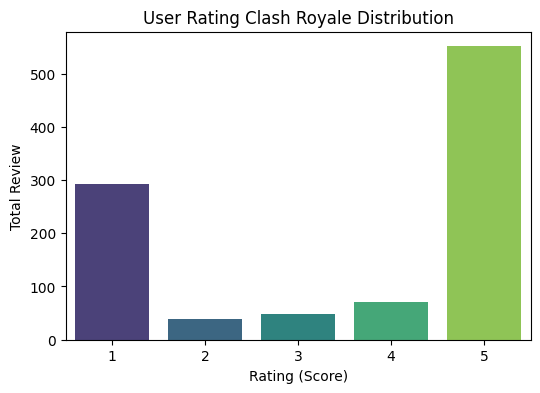

In [ ]:
# buat plot distribusi rating
plt.figure(figsize=(6,4))
sns.countplot(x='score', data=filtered_data, order=sorted(filtered_data['score'].unique()), palette='viridis')
plt.xlabel("Rating (Score)")
plt.ylabel("Total Review")
plt.title("User Rating Clash Royale Distribution")
plt.show()



Saya memvisualisasikan distribusi rating yang sudah di cek sebelumnya diatas tadi. Dapat dilihat bahwa memang distribusinya itu imbalanced alias tidak merata, dimana hasilnya di dominasi oleh rating positif sekali (5) dan sangat buruk (1). Rating menengah jumlahnya masih cukup dekat / imbang.

## Kata Dominan Setiap Rating

In [ ]:
# cek kata dominan per rating
top_words_by_score = {}
for score in sorted(filtered_data['score'].unique()): # rating 1 2 3 4 5
    texts = ' '.join(str(t) for t in filtered_data[filtered_data['score'] == score]['content'] if pd.notna(t)) # gabungin semua teks untuk masing masing rating
    raw_words = texts.split()
    counter = Counter(raw_words)
    top_words_by_score[score] = counter.most_common(10)

print("\n10 kata (RAW) paling sering muncul per rating")
for score, words in top_words_by_score.items():
    print(f"\nRating {score}:")
    for w, f in words:
        print(f"{w}: {f}")


10 kata (RAW) paling sering muncul per rating

Rating 1:
to: 219
the: 208
game: 174
and: 157
a: 116
it: 104
I: 101
is: 90
you: 78
this: 75

Rating 2:
to: 30
the: 29
and: 24
game: 24
a: 21
is: 17
I: 12
for: 11
you: 11
of: 10

Rating 3:
the: 45
to: 34
and: 30
I: 27
game: 26
a: 25
is: 23
but: 22
it: 20
for: 12

Rating 4:
to: 48
game: 45
the: 40
it: 26
and: 26
but: 25
a: 25
I: 24
is: 19
pay: 13

Rating 5:
game: 226
I: 94
and: 93
is: 93
good: 92
the: 91
it: 88
a: 85
fun: 84
to: 81


Disini, saya buat loop untuk mengelompokkan teks berdasarkan setiap rating (1-5) dimana saya menggabungkan semua teks berdasarkan masing-masing stringnya, kemudian di pecah / tokenisasi supaya bisa dihitung jumlah kemunculannya. Kemudian saya mendisplay hasil 10 kata yang paling sering muncul untuk setiap rating. Nah disini dapat dilihat bahwa kata-kata yang sering muncul cenderung kata-kata umum yang tidak bermakna, nah kata-kata ini disebut sebagai stopwords. Hal ini wajar apabila sekarang terdeteksi, hal ini dikarenakan kondisi data masih belum dilakukan text preprocessing, sehingga isi dari datanya masih mengandung stop words alias belum clean.

## Kata yang Tidak Sesuai Standar Bahasa

In [ ]:
# kata-kata yang tidak sesuai standar inggris

english_vocab = set(w.lower() for w in nltk_words.words())  # kamus inggris
all_text = ' '.join(str(t) for t in filtered_data['content'] if pd.notna(t)) # gabung semua content
tokens = [w.lower() for w in all_text.split() if len(w) > 1] # set to lower
tokens = [re.sub(r'[^a-z0-9]', '', w) for w in tokens if w.isascii()]  # remove unnecessary signs
word_counts = Counter(tokens)

non_standard = [(w, c) for w, c in word_counts.items()
                if w not in english_vocab and not w.isdigit() and len(w) > 1]

non_standard_sorted = sorted(non_standard, key=lambda x: x[1], reverse=True)  # sort by frequency

print("\n20 Frekuensi kata tidak standar :\n")
for w, f in non_standard_sorted[:20]:
    print(f"{w}: {f}")


20 Frekuensi kata tidak standar :

cards: 55
players: 44
im: 41
games: 41
playing: 41
mega: 31
has: 29
ive: 28
p2w: 27
years: 27
supercell: 23
evo: 22
played: 20
crashing: 20
crashes: 20
nerf: 19
keeps: 17
trophies: 17
app: 16
decks: 15


Bagian ini bertujuan untuk mengecek kata-kata yang tidak sesuai vocabulary Inggris standar. Semua reviewnya digabung jadi satu tanpa berdasarkan rating, lalu dipecah menjadi token, diubah menjadi huruf kecil, dan dibersihkan dari simbol-simbol non-alfanumerik. Kemudian menampilkan kata yang tidak standar beserta jumlah frekuensi kemunculannya. Dari segi frekuensi, dapat dikatakan kata-kata yang tidak standar ini lumayan banyak, yakni sekitar 2-5% dari total data yang ada. Dimana masih dapat ditoleransi karena campuran antara istilah dalam game dan perluasan dari kata dasar yang ada di vocabnya.

In [ ]:
test_words = ['cards','card','players','player','playing','play','years','year','crashing','crash','trophies','trophy']

for w in test_words:
    if w.lower() in english_vocab:
        status = "standar"
    else:
        status = "tidak standar"
    print(f"{w:10} -> {status}")


cards      -> tidak standar
card       -> standar
players    -> tidak standar
player     -> standar
playing    -> tidak standar
play       -> standar
years      -> tidak standar
year       -> standar
crashing   -> tidak standar
crash      -> standar
trophies   -> tidak standar
trophy     -> standar


Berikut salah satu contoh dari beberapa kata yang tidak standar menurut vocab inggris NLTK, terdapat banyak kata yang sudah merupakan lanjutan dari kata dasar sehingga tidak terdeteksi standar oleh nltknya. Jadi NLTK itu vocabularynya standard based gitu, jadi kata-kata nya harus standar alias kata dasar baru terdeteksi standar.  
Nah untuk selain kata umum, kata kata seperti supercell, deck, nerf, dll itu tergolong tidak standar karena itu sifatnya memang kata-kata / istilah dalam game yang seringkali dipakai oleh para gamers.

# 3. Data Preprocessing

In [ ]:
# rename column untuk mempermudah
X = filtered_data['content']
y = filtered_data['score']

In [ ]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import spacy

# load lemmatizer
nlp = spacy.load("en_core_web_sm")

# stopwords standar & custom stopwords
stop_words = set(stopwords.words('english'))
custom_stopwords = {"game","player","play","level","match","win","lose","one"}


# TF-IDF preprocessing
X_clean_for_tf = []

for text in X:
    text = text.lower()  # lowercase
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # remove URL
    text = re.sub(r'\d+', '', text)  # remove angka
    text = re.sub(r'[^\w\s]', ' ', text)  # remove simbol
    text = re.sub(r'\s+', ' ', text).strip()  # remove spasi berlebih

    tokens = word_tokenize(text)
    tokens = [token for token in tokens if token not in stop_words and token not in custom_stopwords and len(token) > 1]  # remove stopwords & custom

    # lemmatization & POS filtering
    doc = nlp(" ".join(tokens))
    tokens = [token.lemma_ for token in doc if token.pos_ in {'NOUN','VERB','ADJ','ADV'}]

    X_clean_for_tf.append(" ".join(tokens))  # gabung jadi string


# word2vec preprocessing
X_tokens_for_embedding = []

for text in X:
    text = text.lower()  # lower
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # remove URL
    text = re.sub(r'[^a-z\s]', '', text) # hanya huruf + spasi
    text = re.sub(r'\s+', ' ', text).strip()  # hapus spasi berlebih

    tokens = word_tokenize(text)
    tokens = [token for token in tokens if token not in stop_words and len(token) > 1]  # hanya stopwords standar

    # lemmatization & POS filtering
    doc = nlp(" ".join(tokens))
    tokens = [token.lemma_ for token in doc if token.pos_ in {'NOUN','VERB','ADJ','ADV'}]

    X_tokens_for_embedding.append(tokens)  # gabung jadi token


print("TF-IDF example:", X_clean_for_tf[:3])
print("Word2Vec example:", X_tokens_for_embedding[:3])


TF-IDF example: ['', 'good', 'matchmake horrible get level high opponent almost time mega knight power remove mega knight']
Word2Vec example: [[], ['good', 'game'], ['matchmake', 'horrible', 'get', 'level', 'high', 'opponent', 'almost', 'time', 'mega', 'knight', 'power', 'remove', 'mega', 'knight']]


In [ ]:
X[2]

'Matchmaking is horrible, I get 2+ levels higher opponent almost 90% of the time. Mega knight is over powered pls remove mega knight 😡😡.'

Disini, pertama saya load lemmatizer dan define dulu stop words dan custom stop wordsnya nya untuk mendetect dalam bahasa inggris. Stop words itu adalah kata-kata yang sering muncul tapi tidak memberikan makna, contohnya kayak "the", "and", "on", dst.  
Lalu saya membuat preprocessing text untuk TF-IDF dan untuk Word2Vec.
Sebenarnya kedua preprocessing ini kurang lebih sama-sama lower casing, hapus spasi, simbol, angka, kemudian di tokenisasi dan penghapusan stop words. Kemudian dilakukan lemmatization agar tokennya jadi kata dasar serta
melalui penggunaan POS, memastikan token yang digunakan informatif, relevan dengan isi review, dan **tetap mempertahankan makna kata** untuk prediksi rating. Kemudian salah satu yang perlu diperhatikan adalah, TF-IDF hasilnya berupa **string** per dokumen, sedangkan Word2Vec menghasilkan **tokens**.  
Disini dapat dilihat contoh review pada index ke 2, sudah menghasilkan bentuk **token yang efektif sesuai dengan tata bahasa (lemmatization)** dan well preprocessed. Yang menyisakan token / word yang penting untuk digunakan pada saat modelling.



## Splitting Data

In [ ]:
from sklearn.model_selection import train_test_split

# split data for TF-IDF
X_train_tf, X_test_tf, y_train, y_test = train_test_split(X_clean_for_tf, y, test_size=0.2, random_state=42)

# split data for Word2Vec
X_train_tokens, X_test_tokens, y_train_tokens, y_test_tokens = train_test_split(X_tokens_for_embedding, y, test_size=0.2, random_state=42)

print("Ukuran data TF-IDF :")
print("Train:", len(X_train_tf), "| Test:", len(X_test_tf))
print("\nUkuran data (Word2Vec):")
print("Train:", len(X_train_tokens), "| Test:", len(X_test_tokens))


Ukuran data TF-IDF :
Train: 800 | Test: 200

Ukuran data (Word2Vec):
Train: 800 | Test: 200


Disini saya melakukan splitting data sebelum text representation, tujuannya agar menghindari terjadinya data leakage. Dapat dilihat ukuran data trainnya sebanyak 800 rows dengan test nya 200 rows.

# 4. Text Representation

## TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))  # unigram + bigram

X_train_tfidf = tfidf.fit_transform(X_train_tf)
X_test_tfidf = tfidf.transform(X_test_tf)

print("TF-IDF")
print("Shape (train):", X_train_tfidf.shape)
print("Jumlah kata unik :", len(tfidf.vocabulary_))
print("Beberapa vocab:", list(tfidf.vocabulary_.keys())[:20])

TF-IDF
Shape (train): (800, 4600)
Jumlah kata unik : 4600
Beberapa vocab: ['good', 'get', 'annoying', 'game', 'play', 'get annoying', 'annoying game', 'game play', 'trash', 'knight', 'take', 'merge', 'tactic', 'today', 'trash knight', 'knight take', 'take merge', 'merge tactic', 'tactic today', 'love']


TF-IDF ini mengubah teks menjadi angka dengan setiap kata dikombinasikan menjadi bobot numerik dan menilai seberapa penting kata dibandingkan kata di seluruh dokumen. Disitu menggunakan ngram rangenya 1,2 karena kadang kalau ngramnya cuma 1 itu tidak dapat menangkap makna dengan baik. Untuk jumlah kata uniknya max nya kan 5000, disini cuma 4600 artinya memang kombinasi kata uniknya ga sampai 5000.

## Word2Vec

In [ ]:
from gensim.models import Word2Vec

# train Word2Vec hanya pada data train
w2v_model = Word2Vec(sentences=X_train_tokens, vector_size=100, window=5, min_count=2, workers=4) # sg=0 default (CBOW), skip-gram sg=1

# avg vektor kata per dokumen
def avg_vector(tokens, model):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    if len(vectors) == 0:
        return np.zeros(model.vector_size)
    return np.mean(vectors, axis=0)

# convert text to vectors
X_train_w2v = np.array([avg_vector(t, w2v_model) for t in X_train_tokens])
X_test_w2v  = np.array([avg_vector(t, w2v_model) for t in X_test_tokens])

print("Shape X_train Word2Vec:", X_train_w2v.shape)
print("Shape X_test Word2Vec:", X_test_w2v.shape)
print("Jumlah kata unik :", len(w2v_model.wv))
print("Beberapa vocab:", list(w2v_model.wv.key_to_index.keys())[:20])


Shape X_train Word2Vec: (800, 100)
Shape X_test Word2Vec: (200, 100)
Jumlah kata unik : 521
Beberapa vocab: ['game', 'good', 'play', 'fun', 'win', 'get', 'pay', 'card', 'player', 'merge', 'update', 'tactic', 'make', 'love', 'great', 'crash', 'time', 'lose', 'clash', 'go']




Word2Vec mengubah setiap kata menjadi vektor angka untuk menangkap hubungan makna antar kata. Disini dapat dilihat bahwa setiap teks dalam dataset ini sudah berubah menjadi vektor 100 dimensi. Metode ini menangkap konteks kata—kata-kata yang sering muncul di sekitar kata tertentu akan memiliki representasi vektor yang mirip, sifatnya lokal ya bukan global. Dengan begitu, model dapat mengenali hubungan makna antar kata, misalnya kata “win” dan “victory” akan dekat secara vektor karena sering digunakan dalam konteks yang sama.

# 5. Modelling and Tuning

## Imbalance Baseline Modelling

### Random Forest - TF-IDF

In [ ]:
print("Training Baseline Random Forest - TF-IDF (imbalanced)\n")
rf_tfidf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_tfidf.fit(X_train_tfidf, y_train)
preds_rf_tfidf_imb_base = rf_tfidf.predict(X_test_tfidf)
print(classification_report(y_test, preds_rf_tfidf_imb_base))

Training Baseline Random Forest - TF-IDF (imbalanced)

              precision    recall  f1-score   support

           1       0.68      0.72      0.70        57
           2       0.00      0.00      0.00         6
           3       0.00      0.00      0.00         8
           4       0.00      0.00      0.00        15
           5       0.76      0.90      0.82       114

    accuracy                           0.72       200
   macro avg       0.29      0.32      0.30       200
weighted avg       0.63      0.72      0.67       200



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Random Forest - Word2Vec

In [ ]:
print("Training Baseline Random Forest - Word2Vec (imbalanced)\n")
rf_w2v = RandomForestClassifier(n_estimators=100, random_state=42)
rf_w2v.fit(X_train_w2v, y_train)
preds_rf_w2v_imb_base = rf_w2v.predict(X_test_w2v)
print(classification_report(y_test, preds_rf_w2v_imb_base))

Training Baseline Random Forest - Word2Vec (imbalanced)

              precision    recall  f1-score   support

           1       0.62      0.61      0.62        57
           2       0.00      0.00      0.00         6
           3       0.00      0.00      0.00         8
           4       0.00      0.00      0.00        15
           5       0.72      0.90      0.80       114

    accuracy                           0.69       200
   macro avg       0.27      0.30      0.28       200
weighted avg       0.59      0.69      0.63       200



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### XGBoost - TF-IDF

In [ ]:
# encode label biar 0 indexing
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)  # misal 1-5 jadi 0-4
y_test_enc  = le.transform(y_test)

print("Training Baseline XGBoost - TF-IDF (imbalanced)\n")
xgb_tfidf = XGBClassifier(random_state=42, objective='multi:softmax')  # multiclass classification
xgb_tfidf.fit(X_train_tfidf, y_train_enc)

preds_xgb_tfidf_imb_enc = xgb_tfidf.predict(X_test_tfidf)  # inverse ke label asli lagi
preds_xgb_tfidf_imb_base = le.inverse_transform(preds_xgb_tfidf_imb_enc)
print(classification_report(y_test, preds_xgb_tfidf_imb_base))


Training Baseline XGBoost - TF-IDF (imbalanced)

              precision    recall  f1-score   support

           1       0.67      0.60      0.63        57
           2       0.33      0.17      0.22         6
           3       0.00      0.00      0.00         8
           4       0.00      0.00      0.00        15
           5       0.74      0.89      0.80       114

    accuracy                           0.68       200
   macro avg       0.35      0.33      0.33       200
weighted avg       0.62      0.68      0.64       200



### XGBoost - Word2Vec

In [ ]:
# encode label biar 0 indexing
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)  # misal 1-5 jadi 0-4
y_test_enc  = le.transform(y_test)

print("Training Baseline XGBoost - Word2Vec (imbalanced)\n")
xgb_w2v = XGBClassifier(random_state=42, objective='multi:softmax')  # multiclass classification
xgb_w2v.fit(X_train_w2v, y_train_enc)

preds_xgb_w2v_imb_enc = xgb_w2v.predict(X_test_w2v)  # inverse ke label asli lagi
preds_xgb_w2v_imb_base = le.inverse_transform(preds_xgb_w2v_imb_enc)
print(classification_report(y_test, preds_xgb_w2v_imb_base))


Training Baseline XGBoost - Word2Vec (imbalanced)

              precision    recall  f1-score   support

           1       0.58      0.60      0.59        57
           2       0.00      0.00      0.00         6
           3       0.00      0.00      0.00         8
           4       0.00      0.00      0.00        15
           5       0.72      0.86      0.78       114

    accuracy                           0.66       200
   macro avg       0.26      0.29      0.27       200
weighted avg       0.57      0.66      0.61       200



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Pada modelling untuk data imbalance, disini menggunakan 2 model yakni random forest dan XGBoost serta menggunakan 2 text representation yakni TF-IDF dan Word2Vec. Nah modelling-modelling ini menunjukkan performa model yang cenderung bias terhadap kelas yang jumlah datanya paling banyak, yaitu rating 1 dan 5. Hal ini terlihat dari nilai precision, recall dan f1-score yang lebih tinggi pada kelas tersebut dibandingkan kelas lainnya. Performa rating 2,3,4 paling rendah karena jumlah datanya sangat sedikit, sehingga model kurang mampu mengenali pola dari kelas tersebut.



## Imbalance Fine Tuned

### Random Forest - TF-IDF

In [ ]:
print("Tuning Random Forest - TF-IDF (imbalanced)\n")

# define parameters
parameters = {
    'n_estimators': [100, 200],      # jumlah pohon
    'max_depth': [None, 10, 20],     # kedalaman maksimum pohon
    'min_samples_split': [2, 5, 10]  # minimum sample before split
}

# define model
rf_tfidf_imb = RandomForestClassifier(random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # stratified 5-fold CV

# Grid Search CV
grid_rf_tfidf_imb = GridSearchCV(estimator=rf_tfidf_imb, param_grid=parameters, cv=cv,
                            scoring='accuracy', n_jobs=-1, verbose=2)

# tuning
grid_rf_tfidf_imb.fit(X_train_tfidf, y_train)

# best parameters
print("\nBest Parameters (RF TF-IDF imbalanced):")
print(grid_rf_tfidf_imb.best_params_)

Tuning Random Forest - TF-IDF (imbalanced)

Fitting 5 folds for each of 18 candidates, totalling 90 fits

Best Parameters (RF TF-IDF imbalanced):
{'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}


In [ ]:
# prediction & evaluation
best_rf_tfidf_imb = grid_rf_tfidf_imb.best_estimator_
preds_rf_tfidf_imb_tuned = best_rf_tfidf_imb.predict(X_test_tfidf)

print("Classification Report (Tuned RF, TF-IDF, imbalanced) :\n")
print(classification_report(y_test, preds_rf_tfidf_imb_tuned))
print("Accuracy:", accuracy_score(y_test, preds_rf_tfidf_imb_tuned))

Classification Report (Tuned RF, TF-IDF, imbalanced) :

              precision    recall  f1-score   support

           1       0.69      0.75      0.72        57
           2       0.00      0.00      0.00         6
           3       0.00      0.00      0.00         8
           4       0.00      0.00      0.00        15
           5       0.76      0.90      0.83       114

    accuracy                           0.73       200
   macro avg       0.29      0.33      0.31       200
weighted avg       0.63      0.73      0.68       200

Accuracy: 0.73


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Random Forest - Word2Vec

In [ ]:
print("Tuning Random Forest - Word2Vec (imbalanced)\n")

# define parameters
parameters = {
    'n_estimators': [100, 200],       # jumlah pohon
    'max_depth': [None, 10, 20],      # kedalaman maksimum pohon
    'min_samples_split': [2, 5, 10]   # minimum sample before split
}

# define model
rf_w2v_imb = RandomForestClassifier(random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # stratified 5-fold CV

# Grid Search CV
grid_rf_w2v_imb = GridSearchCV(estimator=rf_w2v_imb, param_grid=parameters, cv=cv,
                               scoring='accuracy', n_jobs=-1, verbose=2)

# tuning
grid_rf_w2v_imb.fit(X_train_w2v, y_train)

# best parameters
print("\nBest Parameters (RF Word2Vec imbalanced):")
print(grid_rf_w2v_imb.best_params_)

Tuning Random Forest - Word2Vec (imbalanced)

Fitting 5 folds for each of 18 candidates, totalling 90 fits

Best Parameters (RF Word2Vec imbalanced):
{'max_depth': 20, 'min_samples_split': 10, 'n_estimators': 200}


In [ ]:
# prediction & evaluation
best_rf_w2v_imb = grid_rf_w2v_imb.best_estimator_
preds_rf_w2v_imb_tuned = best_rf_w2v_imb.predict(X_test_w2v)

print("Classification Report (Tuned RF, Word2Vec, imbalanced):")
print(classification_report(y_test, preds_rf_w2v_imb_tuned))
print("Accuracy:", accuracy_score(y_test, preds_rf_w2v_imb_tuned))

Classification Report (Tuned RF, Word2Vec, imbalanced):
              precision    recall  f1-score   support

           1       0.60      0.53      0.56        57
           2       0.00      0.00      0.00         6
           3       0.00      0.00      0.00         8
           4       0.00      0.00      0.00        15
           5       0.70      0.92      0.80       114

    accuracy                           0.68       200
   macro avg       0.26      0.29      0.27       200
weighted avg       0.57      0.68      0.61       200

Accuracy: 0.675


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### XGBoost - TF-IDF

In [ ]:
# encode label biar 0 indexing
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)  # rating 1-5 jadi 0-4
y_test_enc  = le.transform(y_test)

print("Tuning XGBoost - TF-IDF (imbalanced)\n")

# define parameters
parameters = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01],
    'subsample': [0.7, 0.9]
}

# define model
xgb_tfidf_imb = XGBClassifier(random_state=42, objective='multi:softmax')  # multiclass
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # stratified 5-Fold CV

# Grid Search CV
grid_xgb_tfidf_imb = GridSearchCV(estimator=xgb_tfidf_imb, param_grid=parameters, cv=cv,
                                  scoring='accuracy', n_jobs=-1, verbose=2)

# tuning
grid_xgb_tfidf_imb.fit(X_train_tfidf, y_train_enc)

# best parameters
print("\nBest Parameters (XGBoost TF-IDF imbalanced):")
print(grid_xgb_tfidf_imb.best_params_)


Tuning XGBoost - TF-IDF (imbalanced)

Fitting 5 folds for each of 24 candidates, totalling 120 fits

Best Parameters (XGBoost TF-IDF imbalanced):
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.7}


In [ ]:
# prediction & evaluation
best_xgb_tfidf_imb = grid_xgb_tfidf_imb.best_estimator_
preds_xgb_tfidf_enc_imb = best_xgb_tfidf_imb.predict(X_test_tfidf)
preds_xgb_tfidf_imb_tuned = le.inverse_transform(preds_xgb_tfidf_enc_imb)

print("Classification Report (Tuned XGBoost, TF-IDF, imbalanced):\n")
print(classification_report(y_test, preds_xgb_tfidf_imb_tuned))
print("Accuracy:", accuracy_score(y_test, preds_xgb_tfidf_imb_tuned))

Classification Report (Tuned XGBoost, TF-IDF, imbalanced):

              precision    recall  f1-score   support

           1       0.71      0.68      0.70        57
           2       0.00      0.00      0.00         6
           3       0.00      0.00      0.00         8
           4       0.00      0.00      0.00        15
           5       0.73      0.89      0.81       114

    accuracy                           0.70       200
   macro avg       0.29      0.32      0.30       200
weighted avg       0.62      0.70      0.66       200

Accuracy: 0.705


### XGBoost - Word2Vec

In [ ]:
# encode label biar 0 indexing
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc  = le.transform(y_test)

print("Tuning XGBoost - Word2Vec (imbalanced)\n")

# define parameters
parameters = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01],
    'subsample': [0.7, 0.9]
}

# define model
xgb_w2v_imb = XGBClassifier(random_state=42, objective='multi:softmax')  # multiclass
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # stratified 5-Fold CV

# Grid Search CV
grid_xgb_w2v_imb = GridSearchCV(estimator=xgb_w2v_imb, param_grid=parameters, cv=cv,
                                scoring='accuracy', n_jobs=-1, verbose=2)

# tuning
grid_xgb_w2v_imb.fit(X_train_w2v, y_train_enc)

# best parameters
print("\nBest Parameters (XGBoost Word2Vec imbalanced):")
print(grid_xgb_w2v_imb.best_params_)

Tuning XGBoost - Word2Vec (imbalanced)

Fitting 5 folds for each of 24 candidates, totalling 120 fits

Best Parameters (XGBoost Word2Vec imbalanced):
{'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.7}


In [ ]:
# prediction & evaluation
best_xgb_w2v_imb = grid_xgb_w2v_imb.best_estimator_
preds_xgb_w2v_enc_imb = best_xgb_w2v_imb.predict(X_test_w2v)
preds_xgb_w2v_imb_tuned = le.inverse_transform(preds_xgb_w2v_enc_imb)

print("\nClassification Report (Tuned XGBoost, Word2Vec, imbalanced):")
print(classification_report(y_test, preds_xgb_w2v_imb_tuned))
print("Accuracy:", accuracy_score(y_test, preds_xgb_w2v_imb_tuned))


Classification Report (Tuned XGBoost, Word2Vec, imbalanced):
              precision    recall  f1-score   support

           1       0.57      0.68      0.62        57
           2       0.00      0.00      0.00         6
           3       0.00      0.00      0.00         8
           4       0.00      0.00      0.00        15
           5       0.74      0.83      0.78       114

    accuracy                           0.67       200
   macro avg       0.26      0.30      0.28       200
weighted avg       0.58      0.67      0.62       200

Accuracy: 0.67


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model-model yang sudah di fine-tuned pada kondisi data imbalanced bertujuan agar kinerjanya lebih optimal / ada peningkatan dibandingkan baseline. Namun, dari hasilnya, terutama pada metrik precision, recall, dan f1-score dapat dikatakan cukup fluktuatif. Maksudnya adalah pada model -model tersebut mengalami kenaikan di metrik-metrik tersebut, tetapi disertai tradeoffs di metrik itu juga, jadi ada metrik yang naik, tapi metrik lainnnya turun. Contohnya F1 Score naik, tapi ada kelas rating yang berkurang atau menurun nilainya, dan sebaliknya. Sehingga dapat disimpulkan melalui proses fine tuning ini, tidak terdapat kenaikan / peningkatan performa model yang cukup signifikan. Tentunya dipengaruhi oleh distribusi data yang tidak seimbang.


# 6. Performance Evaluation Imbalance

In [ ]:
def safe_metrics(y_true, y_pred):
    return {
        'Accuracy': round(accuracy_score(y_true, y_pred), 3),   # macro tu ngebagi tiap kelas jadi sama semua bobotnya
        'Precision': round(precision_score(y_true, y_pred, average='macro', zero_division=0), 3),
        'Recall': round(recall_score(y_true, y_pred, average='macro', zero_division=0), 3),
        'F1-Score': round(f1_score(y_true, y_pred, average='macro', zero_division=0), 3)}

results = []   # simpen hasil model

models = [
    ('TF-IDF', 'Random Forest', grid_rf_tfidf_imb.best_params_, preds_rf_tfidf_imb_base, preds_rf_tfidf_imb_tuned),
    ('TF-IDF', 'XGBoost', grid_xgb_tfidf_imb.best_params_, preds_xgb_tfidf_imb_base, preds_xgb_tfidf_imb_tuned),
    ('Word2Vec', 'Random Forest', grid_rf_w2v_imb.best_params_, preds_rf_w2v_imb_base, preds_rf_w2v_imb_tuned),
    ('Word2Vec', 'XGBoost', grid_xgb_w2v_imb.best_params_, preds_xgb_w2v_imb_base, preds_xgb_w2v_imb_tuned)]

# loop ke masing masing model
for rep, algo, best_params, base_pred, tuned_pred in models:
    base_metrics = safe_metrics(y_test, base_pred)
    tuned_metrics = safe_metrics(y_test, tuned_pred)

    # baseline
    results.append({
        'Text Representation': rep,
        'Algoritma ML': algo,
        'Best Hyperparameters': '',  # kosongin
        'Version': 'Baseline',
        **base_metrics
    })

    # tuned
    results.append({
        'Text Representation': rep,
        'Algoritma ML': '',  # biar keliatan grupnya
        'Best Hyperparameters': str(best_params),
        'Version': 'Tuned',
        **tuned_metrics
    })

# convert to df
df_summary = pd.DataFrame(results, columns=[
    'Text Representation', 'Algoritma ML', 'Best Hyperparameters', 'Version',
    'Accuracy', 'Precision', 'Recall', 'F1-Score'
])

# show results
print("Summary Performance Evaluation (Baseline vs Tuned):\n")
print(df_summary.to_string(index=False))


Summary Performance Evaluation (Baseline vs Tuned):

Text Representation  Algoritma ML                                                          Best Hyperparameters  Version  Accuracy  Precision  Recall  F1-Score
             TF-IDF Random Forest                                                                               Baseline     0.720      0.288   0.325     0.305
             TF-IDF                            {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}    Tuned     0.730      0.291   0.332     0.310
             TF-IDF       XGBoost                                                                               Baseline     0.680      0.347   0.330     0.331
             TF-IDF               {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.7}    Tuned     0.705      0.289   0.316     0.301
           Word2Vec Random Forest                                                                               Baseline     0.690      0.269   0.3

Dari tabel performa ini, terlihat bahwa semua model yang telah di train itu tidak menunjukkan hasil yang cukup baik. Relate lagi ke data yang sangat tidak balance penyebabnya. Tapi diantara semuanya, Random Forest dengan TF-IDF punya F1-Score tertinggi pada baseline (0.305) dan setelah tuning (0.310) yang menunjukkan performa terbaik dibanding model lain. XGBoost juga hasil akurasinya cukup tinggi pada beberapa kasus, F1-Score-nya juga lumayan tinggi, namun cenderung turun setelah di tuning. Hal ini mengindikasikan model kurang efektif menangani kelas minoritas. Dikarenakan datanya tidak seimbang, maka menjadi penting untuk memusatkan fokus pada F1-Score daripada akurasi. Sehingga dapat disimpulkan apabila melihat dari metrics F1-Score, maka TF-IDF lebih unggul dibandingkan dengan Word2Vec. Selain itu dapat dilihat juga kalau hasil average F1-Score disini itu masih berkisar di 27-33 %. Sekali lagi ini wajar karena memang datanya sangat imbalance dan jumlahnya juga sedikit yang mengakibatkan model susah untuk mempelajari pola.

# 7. Handling Imbalance, Retrain, Re-evaluate, Conclusion

## Imbalance Handling

Dikarenakan persebaran data rating yang terlalu tidak merata alias terpusat pada rating 1 dan 5, maka disini saya melakukan handling imbalance supaya label ratingnya lebih merata antara 1 dengan yang lainnya.

In [ ]:
from imblearn.over_sampling import RandomOverSampler, SMOTE
from collections import Counter

# TF-IDF
ros = RandomOverSampler(random_state=42)
X_train_tfidf_res, y_train_tfidf_res = ros.fit_resample(X_train_tfidf, y_train)

# Word2Vec
smote = SMOTE(random_state=42)
X_train_w2v_res, y_train_w2v_res = smote.fit_resample(X_train_w2v, y_train)

# cek distribusi setelah balancing
print("Distribusi Label Setelah Oversampling")
print("TF-IDF :", Counter(y_train_tfidf_res))
print("Word2Vec :", Counter(y_train_w2v_res))

Distribusi Label Setelah Oversampling
TF-IDF : Counter({5: 437, 1: 437, 2: 437, 4: 437, 3: 437})
Word2Vec : Counter({5: 437, 1: 437, 2: 437, 4: 437, 3: 437})


Disini saya menggunakan teknik Random Oversampling (ROS) untuk TF-IDF karena karakteristik TF-IDF yang berupa sparse matrix dengan nilai frekuensi kata. ROS bekerja dengan memperbanyak data dari kelas minoritas sehingga jumlahnya seimbang dengan yang mayoritas tanpa menambahkan sampel sintetis baru. Hal ini tepat karena sederhana, tidak menambah noise serta efisien secara komputasi.
Pada Word2Vec, saya menggunakan SMOTE (Synthetic Minority Oversampling Technique), yakni membuat sampel sintetis baru melalui proses interpolasi antar titik dalam ruang vektor kelas minoritas. Bertujuan untuk menjaga representasi semantik antar kata karena embedding menghasilkan fitur kontinu.
Disini dapat dilihat bahwa hasil dari proses balancingnya sudah berhasil, dimana setiap label rating sudah imbang persebarannya.



## Balanced Baseline Modelling

### Random Forest - TF-IDF

In [ ]:
print("Training Baseline Random Forest - TF-IDF (balanced)\n")
rf_tfidf_res = RandomForestClassifier(n_estimators=100, random_state=42)
rf_tfidf_res.fit(X_train_tfidf_res, y_train_tfidf_res)
preds_rf_tfidf_bal_base = rf_tfidf_res.predict(X_test_tfidf)
print(classification_report(y_test, preds_rf_tfidf_bal_base))
print("Accuracy:", accuracy_score(y_test, preds_rf_tfidf_bal_base))

Training Baseline Random Forest - TF-IDF (balanced)

              precision    recall  f1-score   support

           1       0.65      0.68      0.67        57
           2       0.00      0.00      0.00         6
           3       0.00      0.00      0.00         8
           4       0.12      0.07      0.09        15
           5       0.78      0.85      0.81       114

    accuracy                           0.69       200
   macro avg       0.31      0.32      0.31       200
weighted avg       0.64      0.69      0.66       200

Accuracy: 0.685


### Random Forest - Word2Vec

In [ ]:
print("Training Baseline Random Forest - Word2Vec (balanced)\n")
rf_w2v_res = RandomForestClassifier(n_estimators=100, random_state=42)
rf_w2v_res.fit(X_train_w2v_res, y_train_w2v_res)
preds_rf_w2v_bal_base = rf_w2v_res.predict(X_test_w2v)
print(classification_report(y_test, preds_rf_w2v_bal_base))
print("Accuracy:", accuracy_score(y_test, preds_rf_w2v_bal_base))

Training Baseline Random Forest - Word2Vec (balanced)

              precision    recall  f1-score   support

           1       0.56      0.75      0.64        57
           2       0.00      0.00      0.00         6
           3       0.00      0.00      0.00         8
           4       0.10      0.07      0.08        15
           5       0.83      0.77      0.80       114

    accuracy                           0.66       200
   macro avg       0.30      0.32      0.30       200
weighted avg       0.64      0.66      0.64       200

Accuracy: 0.66


### XGBoost - TF-IDF

In [ ]:
# encode label biar 0 indexing
le = LabelEncoder()
y_train_tfidf_enc = le.fit_transform(y_train_tfidf_res)
y_test_enc = le.transform(y_test)

print("Training Baseline XGBoost - TF-IDF (balanced)\n")
xgb_tfidf_res = XGBClassifier(random_state=42, objective='multi:softmax')
xgb_tfidf_res.fit(X_train_tfidf_res, y_train_tfidf_enc)

preds_xgb_tfidf_bal_enc = xgb_tfidf_res.predict(X_test_tfidf)
preds_xgb_tfidf_bal_base = le.inverse_transform(preds_xgb_tfidf_bal_enc)  # sesuai pola RF

print(classification_report(y_test, preds_xgb_tfidf_bal_base))
print("Accuracy:", accuracy_score(y_test, preds_xgb_tfidf_bal_base))

Training Baseline XGBoost - TF-IDF (balanced)

              precision    recall  f1-score   support

           1       0.64      0.61      0.62        57
           2       0.33      0.17      0.22         6
           3       0.00      0.00      0.00         8
           4       0.00      0.00      0.00        15
           5       0.75      0.88      0.81       114

    accuracy                           0.68       200
   macro avg       0.34      0.33      0.33       200
weighted avg       0.62      0.68      0.65       200

Accuracy: 0.68


### XGBoost - Word2Vec

In [ ]:
# encode label biar 0 indexing
le = LabelEncoder()
y_train_w2v_enc = le.fit_transform(y_train_w2v_res)
y_test_enc = le.transform(y_test)

print("Training Baseline XGBoost - Word2Vec (balanced)\n")
xgb_w2v_res = XGBClassifier(random_state=42, objective='multi:softmax')
xgb_w2v_res.fit(X_train_w2v_res, y_train_w2v_enc)

preds_xgb_w2v_bal_enc = xgb_w2v_res.predict(X_test_w2v)
preds_xgb_w2v_bal_base = le.inverse_transform(preds_xgb_w2v_bal_enc)  # sesuai pola TF-IDF

print(classification_report(y_test, preds_xgb_w2v_bal_base))
print("Accuracy:", accuracy_score(y_test, preds_xgb_w2v_bal_base))


Training Baseline XGBoost - Word2Vec (balanced)

              precision    recall  f1-score   support

           1       0.60      0.49      0.54        57
           2       0.00      0.00      0.00         6
           3       0.00      0.00      0.00         8
           4       0.25      0.27      0.26        15
           5       0.76      0.83      0.79       114

    accuracy                           0.64       200
   macro avg       0.32      0.32      0.32       200
weighted avg       0.62      0.64      0.63       200

Accuracy: 0.635


Pada modelling untuk data yang sudah balance, model-model ini menunjukkan performa yang lagi-lagi masih bias terhadap kelas yang jumlah datanya paling banyak, yaitu rating 1 dan 5 dengan sedikit peningkatan pada rating 4. Walaupun sudah di balance datanya, metrik-metrik penilaian ini masih cenderung fluktuatif disertai trade-offs, jadi kayak precision naik, recallnya turun, f1 dan akurasi juga begitu. Tapi jika diperhatikan lebih dalam, F1 Score mengalami peningkatan yang menunjukkan bahwa datanya sudah lebih merata. Hal ini menunjukkan bahwa balancing membantu model belajar lebih adil ke kelas minoritas, contohnya rating 4, tapi bukan jaminan performa langsung tinggi. Faktor data, representasi, dan kompleksitas model tetap menentukan hasil akhir.







## Balanced Fine Tuned

### Random Forest - TF-IDF

In [ ]:
print("Tuning Random Forest - TF-IDF (balanced)\n")

# define parameters
parameters = {
    'n_estimators': [100, 200],      # jumlah pohon
    'max_depth': [None, 10, 20],     # kedalaman maksimum pohon
    'min_samples_split': [2, 5, 10]  # minimum sample sebelum split
}

# define model
rf_tfidf_bal = RandomForestClassifier(random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Grid Search CV
grid_rf_tfidf_bal = GridSearchCV(estimator=rf_tfidf_bal, param_grid=parameters, cv=cv,
                                 scoring='accuracy', n_jobs=-1, verbose=2)

# tuning
grid_rf_tfidf_bal.fit(X_train_tfidf_res, y_train_tfidf_res)

# best parameters
print("Best Parameters (RF TF-IDF balanced) :")
print(grid_rf_tfidf_bal.best_params_)

Tuning Random Forest - TF-IDF (balanced)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Parameters (RF TF-IDF balanced) :
{'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}


In [ ]:
# prediction & evaluation
best_rf_tfidf_bal = grid_rf_tfidf_bal.best_estimator_
preds_rf_tfidf_bal_tuned = best_rf_tfidf_bal.predict(X_test_tfidf)

print("Classification Report (Tuned RF, TF-IDF, balanced) :\n")
print(classification_report(y_test, preds_rf_tfidf_bal_tuned))
print("Accuracy:", accuracy_score(y_test, preds_rf_tfidf_bal_tuned))

Classification Report (Tuned RF, TF-IDF, balanced) :

              precision    recall  f1-score   support

           1       0.68      0.70      0.69        57
           2       0.50      0.17      0.25         6
           3       0.00      0.00      0.00         8
           4       0.14      0.20      0.16        15
           5       0.77      0.75      0.76       114

    accuracy                           0.65       200
   macro avg       0.42      0.36      0.37       200
weighted avg       0.66      0.65      0.65       200

Accuracy: 0.65


### Random Forest - Word2Vec

In [ ]:
print("\nTuning Random Forest - Word2Vec (balanced)\n")

# define parameters
parameters = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# define model
rf_w2v_bal = RandomForestClassifier(random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Grid Search CV
grid_rf_w2v_bal = GridSearchCV(estimator=rf_w2v_bal, param_grid=parameters, cv=cv,
                               scoring='accuracy', n_jobs=-1, verbose=2)

# tuning
grid_rf_w2v_bal.fit(X_train_w2v_res, y_train_w2v_res)

# best parameters
print("Best Parameters (RF Word2Vec balanced) :")
print(grid_rf_w2v_bal.best_params_)


Tuning Random Forest - Word2Vec (balanced)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Parameters (RF Word2Vec balanced) :
{'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}


In [ ]:
# prediction & evaluation
best_rf_w2v_bal = grid_rf_w2v_bal.best_estimator_
preds_rf_w2v_bal_tuned = best_rf_w2v_bal.predict(X_test_w2v)

print("Classification Report (Tuned RF, Word2Vec, balanced) :\n")
print(classification_report(y_test, preds_rf_w2v_bal_tuned))
print("Accuracy:", accuracy_score(y_test, preds_rf_w2v_bal_tuned))

Classification Report (Tuned RF, Word2Vec, balanced) :

              precision    recall  f1-score   support

           1       0.56      0.75      0.64        57
           2       0.00      0.00      0.00         6
           3       0.00      0.00      0.00         8
           4       0.10      0.07      0.08        15
           5       0.83      0.77      0.80       114

    accuracy                           0.66       200
   macro avg       0.30      0.32      0.30       200
weighted avg       0.64      0.66      0.64       200

Accuracy: 0.66


### XGBoost - TF-IDF

In [ ]:
print("\nTuning XGBoost - TF-IDF (balanced)\n")

# encode label 0-indexing
le = LabelEncoder()
y_train_tfidf_enc = le.fit_transform(y_train_tfidf_res)
y_test_enc = le.transform(y_test)

# define parameters
parameters = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01],
    'subsample': [0.7, 0.9]
}

# define model
xgb_tfidf_bal = XGBClassifier(random_state=42, objective='multi:softmax')
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Grid Search CV
grid_xgb_tfidf_bal = GridSearchCV(estimator=xgb_tfidf_bal, param_grid=parameters, cv=cv,
                                  scoring='accuracy', n_jobs=-1, verbose=2)

# tuning
grid_xgb_tfidf_bal.fit(X_train_tfidf_res, y_train_tfidf_enc)

# best parameters
print("Best Parameters (XGBoost TF-IDF balanced) :")
print(grid_xgb_tfidf_bal.best_params_)


Tuning XGBoost - TF-IDF (balanced)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Parameters (XGBoost TF-IDF balanced) :
{'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.7}


In [ ]:
# prediction & evaluation
best_xgb_tfidf_bal = grid_xgb_tfidf_bal.best_estimator_
preds_xgb_tfidf_bal_enc = best_xgb_tfidf_bal.predict(X_test_tfidf)
preds_xgb_tfidf_bal_tuned = le.inverse_transform(preds_xgb_tfidf_bal_enc)

print("Classification Report (Tuned XGBoost, TF-IDF, balanced) :\n")
print(classification_report(y_test, preds_xgb_tfidf_bal_tuned))
print("Accuracy:", accuracy_score(y_test, preds_xgb_tfidf_bal_tuned))

Classification Report (Tuned XGBoost, TF-IDF, balanced) :

              precision    recall  f1-score   support

           1       0.65      0.65      0.65        57
           2       0.25      0.17      0.20         6
           3       0.00      0.00      0.00         8
           4       0.14      0.07      0.09        15
           5       0.77      0.86      0.81       114

    accuracy                           0.69       200
   macro avg       0.36      0.35      0.35       200
weighted avg       0.64      0.69      0.66       200

Accuracy: 0.685


### XGBoost - Word2Vec

In [ ]:
print("\nTuning XGBoost - Word2Vec (balanced)\n")

# encode label 0-indexing
le = LabelEncoder()
y_train_w2v_enc = le.fit_transform(y_train_w2v_res)
y_test_enc = le.transform(y_test)

# define parameters
parameters = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01],
    'subsample': [0.7, 0.9]
}

# define model
xgb_w2v_bal = XGBClassifier(random_state=42, objective='multi:softmax')
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Grid Search CV
grid_xgb_w2v_bal = GridSearchCV(estimator=xgb_w2v_bal, param_grid=parameters, cv=cv,
                                scoring='accuracy', n_jobs=-1, verbose=2)

# tuning
grid_xgb_w2v_bal.fit(X_train_w2v_res, y_train_w2v_enc)

# best parameters
print("Best Parameters (XGBoost Word2Vec balanced) :")
print(grid_xgb_w2v_bal.best_params_)



Tuning XGBoost - Word2Vec (balanced)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Parameters (XGBoost Word2Vec balanced) :
{'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.7}


In [ ]:
# prediction & evaluation
best_xgb_w2v_bal = grid_xgb_w2v_bal.best_estimator_
preds_xgb_w2v_bal_enc = best_xgb_w2v_bal.predict(X_test_w2v)
preds_xgb_w2v_bal_tuned = le.inverse_transform(preds_xgb_w2v_bal_enc)

print("Classification Report (Tuned XGBoost, Word2Vec, balanced) :\n")
print(classification_report(y_test, preds_xgb_w2v_bal_tuned))
print("Accuracy:", accuracy_score(y_test, preds_xgb_w2v_bal_tuned))


Classification Report (Tuned XGBoost, Word2Vec, balanced) :

              precision    recall  f1-score   support

           1       0.57      0.60      0.58        57
           2       0.00      0.00      0.00         6
           3       0.00      0.00      0.00         8
           4       0.25      0.20      0.22        15
           5       0.80      0.82      0.81       114

    accuracy                           0.66       200
   macro avg       0.32      0.32      0.32       200
weighted avg       0.63      0.66      0.64       200

Accuracy: 0.655


Nah setelah data sudah balance dan dilakukan tuning dari model baseline, disini menunjukkan lumayan adanya peningkatan positif dari metric-metric yang ada, serta kelas minoritas mulai lebih keliatan hasilnya, tidak lagi 0. Serta walaupun tetap ada tradeoffsnya (nilai naik turun) tapi cenderung peningkatannya lebih banyak sehingga menandakan bahwa proses tuningnya lumayan berhasil untuk menangani data rating yang sudah di balancing.

# Performance Evaluation Balanced

In [ ]:
results_bal = []   # simpen hasil model

models_bal = [
    ('TF-IDF', 'Random Forest', grid_rf_tfidf_bal.best_params_, preds_rf_tfidf_bal_base, preds_rf_tfidf_bal_tuned),
    ('TF-IDF', 'XGBoost', grid_xgb_tfidf_bal.best_params_, preds_xgb_tfidf_bal_base, preds_xgb_tfidf_bal_tuned),
    ('Word2Vec', 'Random Forest', grid_rf_w2v_bal.best_params_, preds_rf_w2v_bal_base, preds_rf_w2v_bal_tuned),
    ('Word2Vec', 'XGBoost', grid_xgb_w2v_bal.best_params_, preds_xgb_w2v_bal_base, preds_xgb_w2v_bal_tuned)
]

# loop ke masing masing model
for rep, algo, best_params, base_pred, tuned_pred in models_bal:
    base_metrics = safe_metrics(y_test, base_pred)
    tuned_metrics = safe_metrics(y_test, tuned_pred)

    # baseline
    results_bal.append({
        'Text Representation': rep,
        'Algoritma ML': algo,
        'Best Hyperparameters': '',
        'Version': 'Baseline',
        **base_metrics
    })

    # tuned
    results_bal.append({
        'Text Representation': rep,
        'Algoritma ML': '',
        'Best Hyperparameters': str(best_params),
        'Version': 'Tuned',
        **tuned_metrics
    })

# convert to df
df_summary_bal = pd.DataFrame(results_bal, columns=[
    'Text Representation', 'Algoritma ML', 'Best Hyperparameters', 'Version',
    'Accuracy', 'Precision', 'Recall', 'F1-Score'
])

print("Summary Performance Evaluation (Baseline vs Tuned, Balanced):\n")
print(df_summary_bal.to_string(index=False))


Summary Performance Evaluation (Baseline vs Tuned, Balanced):

Text Representation  Algoritma ML                                                          Best Hyperparameters  Version  Accuracy  Precision  Recall  F1-Score
             TF-IDF Random Forest                                                                               Baseline     0.685      0.310   0.320     0.313
             TF-IDF                            {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}    Tuned     0.650      0.418   0.365     0.373
             TF-IDF       XGBoost                                                                               Baseline     0.680      0.344   0.332     0.331
             TF-IDF               {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.7}    Tuned     0.685      0.362   0.348     0.350
           Word2Vec Random Forest                                                                               Baseline     0.660      0

Setelah melakukan balancing, terlihat bahwa metric penilaian accuracy memang mengalami penurunan, hal ini wajar karena data labelnya sudah lebih terdistribusi merata. Di sisi lain, pada precision, F1, recall, mengalami kenaikan yang menjadi tanda bahwa model sudah lebih dapat menangkap pola dari kelas label minoritas. Sekarang dapat dilihat bahwa terutama F1-Score, hasilnya tidak ada lagi yang dibawah 30, dari yang tadi awalnya kisaran 27-33%, sekarang sudah berhasil naik jadi 30-37%, dimana sangat signifikan sekali kenaikannya.Dengan demikian, balancing membantu meningkatkan performa model terhadap kelas minoritas, meskipun akurasi nya dikorbankan, namun F1-Score menjadi metrik utama untuk menilai model pada dataset tidak seimbang.

## Compare Performance Evaluation

In [ ]:
results_all = []

# imbalance
models_imb = [
    ('TF-IDF', 'Random Forest', grid_rf_tfidf_imb.best_params_, preds_rf_tfidf_imb_base, preds_rf_tfidf_imb_tuned),
    ('TF-IDF', 'XGBoost', grid_xgb_tfidf_imb.best_params_, preds_xgb_tfidf_imb_base, preds_xgb_tfidf_imb_tuned),
    ('Word2Vec', 'Random Forest', grid_rf_w2v_imb.best_params_, preds_rf_w2v_imb_base, preds_rf_w2v_imb_tuned),
    ('Word2Vec', 'XGBoost', grid_xgb_w2v_imb.best_params_, preds_xgb_w2v_imb_base, preds_xgb_w2v_imb_tuned)
]

# loop ke masing masing model
for rep, algo, best_params, base_pred, tuned_pred in models_imb:
    base_metrics = safe_metrics(y_test, base_pred)
    tuned_metrics = safe_metrics(y_test, tuned_pred)

    # baseline
    results_all.append({
        'Data Condition': 'Imbalanced',
        'Text Representation': rep,
        'Algoritma ML': algo,
        'Best Hyperparameters': '',
        'Version': 'Baseline',
        **base_metrics
    })

    # tuned
    results_all.append({
        'Data Condition': 'Imbalanced',
        'Text Representation': rep,
        'Algoritma ML': '',
        'Best Hyperparameters': str(best_params),
        'Version': 'Tuned',
        **tuned_metrics
    })

# balanced
models_bal = [
    ('TF-IDF', 'Random Forest', grid_rf_tfidf_bal.best_params_, preds_rf_tfidf_bal_base, preds_rf_tfidf_bal_tuned),
    ('TF-IDF', 'XGBoost', grid_xgb_tfidf_bal.best_params_, preds_xgb_tfidf_bal_base, preds_xgb_tfidf_bal_tuned),
    ('Word2Vec', 'Random Forest', grid_rf_w2v_bal.best_params_, preds_rf_w2v_bal_base, preds_rf_w2v_bal_tuned),
    ('Word2Vec', 'XGBoost', grid_xgb_w2v_bal.best_params_, preds_xgb_w2v_bal_base, preds_xgb_w2v_bal_tuned)
]

# loop ke masing masing model
for rep, algo, best_params, base_pred, tuned_pred in models_bal:
    base_metrics = safe_metrics(y_test, base_pred)
    tuned_metrics = safe_metrics(y_test, tuned_pred)

    # baseline
    results_all.append({
        'Data Condition': 'Balanced',
        'Text Representation': rep,
        'Algoritma ML': algo,
        'Best Hyperparameters': '',
        'Version': 'Baseline',
        **base_metrics
    })

    # tuned
    results_all.append({
        'Data Condition': 'Balanced',
        'Text Representation': rep,
        'Algoritma ML': '',
        'Best Hyperparameters': str(best_params),
        'Version': 'Tuned',
        **tuned_metrics
    })

# convert to DataFrame
df_summary_all = pd.DataFrame(results_all, columns=[
    'Data Condition', 'Text Representation', 'Algoritma ML', 'Best Hyperparameters', 'Version',
    'Accuracy', 'Precision', 'Recall', 'F1-Score'
])


print("Summary Performance Evaluation (Imbalanced vs Balanced, Baseline vs Tuned):\n")
print(df_summary_all.to_string(index=False))


Summary Performance Evaluation (Imbalanced vs Balanced, Baseline vs Tuned):

Data Condition Text Representation  Algoritma ML                                                          Best Hyperparameters  Version  Accuracy  Precision  Recall  F1-Score
    Imbalanced              TF-IDF Random Forest                                                                               Baseline     0.720      0.288   0.325     0.305
    Imbalanced              TF-IDF                            {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}    Tuned     0.730      0.291   0.332     0.310
    Imbalanced              TF-IDF       XGBoost                                                                               Baseline     0.680      0.347   0.330     0.331
    Imbalanced              TF-IDF               {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.7}    Tuned     0.705      0.289   0.316     0.301
    Imbalanced            Word2Vec Random Forest

## Conclusion

Dari tabel performa gabungan, dapat dilihat bahwa semua model pada kondisi imbalanced maupun balanced itu tidak ada yang menunjukkan hasil yang sangat tinggi (semuanya kurang bagus), hal ini wajar karena memang dari awal datasetnya sangat tidak seimbang, terlalu fokus pada kelas rating 1 dan 5. Fokus pada F1-Score menjadi kunci, karena metrik ini menilai kemampuan model mengenali kelas minoritas dibandingkan metrik lainnya. Dari semua kombinasi, Random Forest dengan TF-IDF menunjukkan performa terbaik, baik pada kondisi imbalanced maupun setelah balancing, dengan F1-Score tertinggi dan peningkatan signifikan pada versi tuned. Meskipun akurasi kadang lebih tinggi pada model lain, seperti XGBoost, tapi nilai F1-Score-nya lebih rendah, yang menandakan kurang efektif dalam menangani kelas minoritas. Balancing membantu meningkatkan precision, recall, dan F1-Score, sehingga model lebih adil dalam memprediksi semua kelas. Dengan demikian, **Random Forest + TF-IDF** direkomendasikan sebagai model terbaik untuk dataset ini, terutama yang sudah di proses handling imbalance (balanced) dan sudah di fine tuning (tuned).

# 8. Link Video Penjelasan

Link :   
https://binusianorg-my.sharepoint.com/personal/jonathan_gani_binus_ac_id/_layouts/15/guestaccess.aspx?share=Eb3YakMK9L9DgIyU-j53WuQBnskV-Gp1jQh97x975xVEug&nav=eyJyZWZlcnJhbEluZm8iOnsicmVmZXJyYWxBcHAiOiJPbmVEcml2ZUZvckJ1c2luZXNzIiwicmVmZXJyYWxBcHBQbGF0Zm9ybSI6IldlYiIsInJlZmVycmFsTW9kZSI6InZpZXciLCJyZWZlcnJhbFZpZXciOiJNeUZpbGVzTGlua0NvcHkifX0&e=LRqySf
